# Generative Adversarial Networks

## Load dataset

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [25]:
if not os.path.exists('./gan_imgs'):
    os.mkdir('gan_imgs/')

In [10]:
import glob
import cv2
from tensorflow.keras.datasets import mnist

((Train_x, Train_lbl),(Test_x, Test_lbl)) = mnist.load_data()

Train_x = 2 * (Train_x / 255) - 1
Test_x = 2 * (Test_x / 255) - 1

## Models

In [11]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, BatchNormalization, Reshape, Input

In [12]:
SEED_SIZE = 100
IMG_SIZE = Train_x[0].shape

Train_x = Train_x.reshape(-1, np.prod(IMG_SIZE))
Test_x = Train_x.reshape(-1, np.prod(IMG_SIZE))

### Generator

In [13]:
def make_Generator():
    model = Sequential([
        Dense(256, input_shape = (SEED_SIZE, ), activation = 'LeakyReLU'), 
        BatchNormalization(),
       
        Dense(512, activation = 'LeakyReLU'), 
        BatchNormalization(),
       
        Dense(1024, activation = 'LeakyReLU'), 
        BatchNormalization(),
        
        Dense( np.prod(IMG_SIZE) , activation = 'tanh')
    ])
    return model

Generator = make_Generator()

### Discriminator

In [14]:
def make_Discriminator():
    model = Sequential([
        Dense(512, input_shape = (np.prod(IMG_SIZE),) , activation = 'LeakyReLU'), 
        Dense(256, activation = 'LeakyReLU'), 
        Dense( 1 , activation = 'sigmoid')
    ])
    return model
    
Discriminator = make_Discriminator()

In [15]:
Discriminator.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Z = Input(shape=(SEED_SIZE, ))
Img = Generator(Z)

Discriminator.trainable = False

Fake_pred = Discriminator(Img)

Combined_model = Model(Z, Fake_pred)

Combined_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the GAN

In [32]:
BATCH__SIZE = 32
EPOCHS = 40_000
Sample_Period = 1_000 

ones = np.ones(BATCH__SIZE)
zeros = np.zeros(BATCH__SIZE)

D_Loss = []
G_Loss = []

In [22]:
def Sample_Images(epoch):
    rows, cols = 5,5

    noise = np.random.randn(rows*cols, SEED_SIZE)
    imgs = Generator(noise)

    imgs = 0.5*imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i][j].imshow( tf.reshape(imgs[idx], IMG_SIZE), cmap='gray' )
            axs[i][j].axis("off")
            idx += 1
    fig.savefig("gan_imgs/%d.png" % epoch)
    plt.close()

In [33]:
for epoch in range(EPOCHS+1):

    idx = np.random.randint(0, Train_x.shape[0], BATCH__SIZE)
    real_imgs = Train_x[idx]

    noise =  np.random.randn(BATCH__SIZE, SEED_SIZE)
    fake_imgs = Generator(noise)

    #Discriminator
    D_Loss_real, D_accu_real = Discriminator.train_on_batch(real_imgs, ones)
    D_Loss_fake, D_accu_fake = Discriminator.train_on_batch(fake_imgs, zeros)

    d_loss = 0.5 * (D_Loss_real + D_Loss_fake)
    d_accu = 0.5 * (D_accu_real + D_accu_fake)

    D_Loss.append(d_loss)
    
    
    #Generator
    noise =  np.random.randn(BATCH__SIZE, SEED_SIZE)
    G_loss = Combined_model.train_on_batch(noise, ones)

    G_Loss.append(G_loss[0])

    if epoch % 1000 == 0:
        print("Epoch: {}, D_Loss: {}, D_Acc: {}, G_Loss: {}".format(epoch, d_loss, d_accu, G_loss[0]))
    
    if epoch % Sample_Period == 0:
        Sample_Images(epoch)


Epoch: 0, D_Loss: 0.24845510721206665, D_Acc: 0.84375, G_Loss: 4.867747783660889
Epoch: 1000, D_Loss: 0.39785127341747284, D_Acc: 0.78125, G_Loss: 3.3258635997772217
Epoch: 2000, D_Loss: 0.4774848073720932, D_Acc: 0.8125, G_Loss: 3.441727638244629
Epoch: 3000, D_Loss: 0.23315511643886566, D_Acc: 0.859375, G_Loss: 4.825714111328125
Epoch: 4000, D_Loss: 0.45218437910079956, D_Acc: 0.828125, G_Loss: 3.306318759918213
Epoch: 5000, D_Loss: 0.11997048929333687, D_Acc: 0.953125, G_Loss: 3.5232393741607666
Epoch: 6000, D_Loss: 0.4461760073900223, D_Acc: 0.875, G_Loss: 2.9107046127319336
Epoch: 7000, D_Loss: 0.16636693477630615, D_Acc: 0.953125, G_Loss: 3.239375591278076
Epoch: 8000, D_Loss: 0.18590725399553776, D_Acc: 0.9375, G_Loss: 2.6360321044921875
Epoch: 9000, D_Loss: 0.2055489495396614, D_Acc: 0.875, G_Loss: 3.689666748046875
Epoch: 10000, D_Loss: 0.2860530614852905, D_Acc: 0.921875, G_Loss: 2.9279227256774902
Epoch: 11000, D_Loss: 0.178400456905365, D_Acc: 0.9375, G_Loss: 4.026742935180

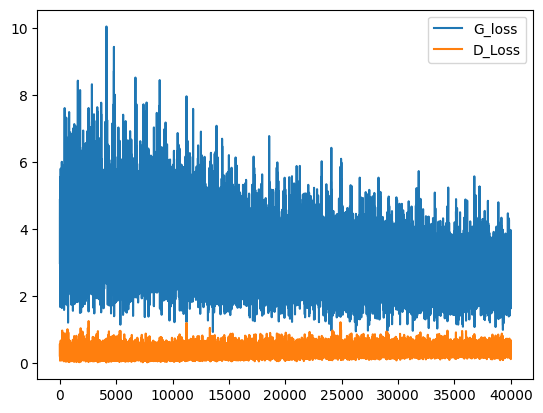

In [34]:
plt.plot(G_Loss, label = 'G_loss')
plt.plot(D_Loss, label = 'D_Loss')
plt.legend()

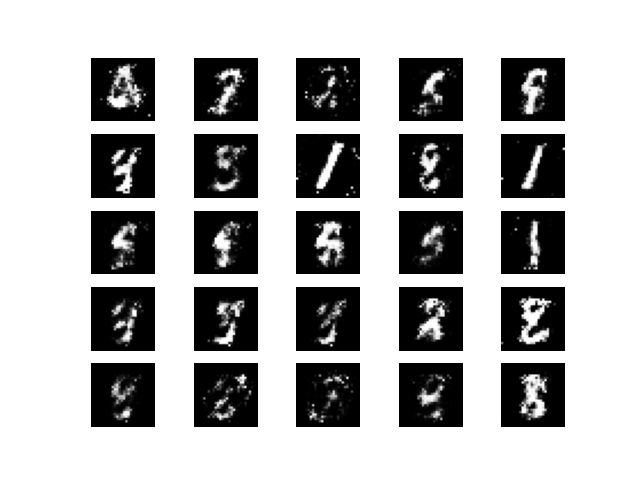

In [41]:
import imageio
from IPython.display import Image,clear_output
import glob
import cv2


imgs = [cv2.imread(img) for img in glob.glob('./gan_imgs/*')]
imageio.mimsave('gan.gif', imgs, fps = 5)
Image( './gan.gif', format='gif')